# vnf

In [1]:
from numbers import Real

import numpy as np
import numpy.typing as npt


def _energy_decay(alpha: float, number_of_impulses: int) -> float:
    """
    Given the alpha value and the number of impulses, what is the target decay?
    L_db = 20 log_10 (exp(-alpha M))
    """
    return 20.0 * np.log10(np.exp(-alpha * number_of_impulses))


def _inverse_energy_decay(target_decay: float, number_of_impulses: int) -> float:
    """
    Given the energy decay and the number of impulses, what is the alpha?
    """
    return (-1 / number_of_impulses) * np.log(np.power(10, target_decay / 20))


def _make_decaying_sample(size: int, alpha: float) -> npt.NDArray[np.float32]:
    rng = np.random.default_rng()
    samples = np.zeros((size,), dtype=np.float32)
    for i in range(size):
        samples[i] = np.exp(-alpha * i) * rng.choice([1, -1]) # * rng.uniform(0.5, 2)
    return samples


def velvet_noise(sample_rate: Real,
                 filter_length_ms: Real,
                 number_of_impulses: int,
                 target_decay: float) -> npt.NDArray[np.float32]:
    """
    Create a velvet noise discrete-time signal.
    :param sample_rate: the sample rate of the returned signal
    :param filter_length_ms: the total milliseconds of the returned signal
    :param number_of_impulses: the number of non-zero samples in the returned noise
    :param target_decay: the amount of decay applied on non-zero samples
    :return: a velvet noise. The returned data bit-rate is 32-bit
    """

    # Parameter value and type check
    if sample_rate <= 0:
        raise ValueError(f'The sample rate should be a positive real number. Got {sample_rate}')
    if filter_length_ms <= 0:
        raise ValueError(f'The filter length should be a positive real number. Got {filter_length_ms}')
    if number_of_impulses <= 0:
        raise ValueError(f'The total number of impulses cannot be non-positive. Got {number_of_impulses}')
    if target_decay > 0:
        raise ValueError(f'The target decay is expected to be negative. Got {target_decay}')

    rng = np.random.default_rng()
    filter_size = np.int32(sample_rate * filter_length_ms / 1000)

    velvet_noise_return = np.zeros((filter_size,), dtype=np.float32)

    alpha = _inverse_energy_decay(target_decay, number_of_impulses)

    indices = np.sort(rng.choice(filter_size, size=(number_of_impulses,), replace=False, shuffle=False))
    decaying_sample = _make_decaying_sample(number_of_impulses, alpha)
    velvet_noise_return[indices] = decaying_sample

    return velvet_noise_return

# plot

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def plot_freqz(w, h):
    """
    A helper function to acquire a plot directly from `scipy.signal.freqz` function.
    """
    fig, ax1 = plt.subplots()

    ax1.set_title('Digital filter frequency response')
    ax1.plot(w, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')


def no_output(*args):
    pass

In [5]:
import matplotlib.pyplot as plt
from scipy import signal

The velvet noise proposed by the study has the following parameters:
* $f_s$: the sample rate
* $\rho$: the density of non-zero impulses
* $\alpha$: the decay rate

And when it comes to production, we use these parameters:
* $L_s$: the length of the filter in milliseconds
* $M$: the number of impulses (non-zero samples)
* $L_\text{dB}$: the target decay

We also need the sample rate $f_s$. 

In [3]:
sr = 44100.0

We create our first velvet noise filter with the following parameters:
- $L_s$, the length of the filter in milliseconds, to be $10$
- $M$, the number of impulses, to be $8$
- $L_\text{dB}$, the target decay, to be $-5\text{dB}$

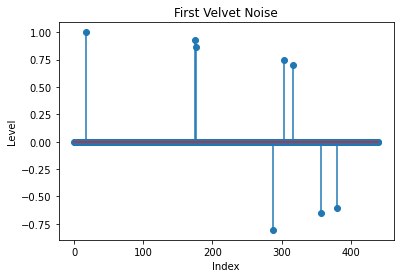

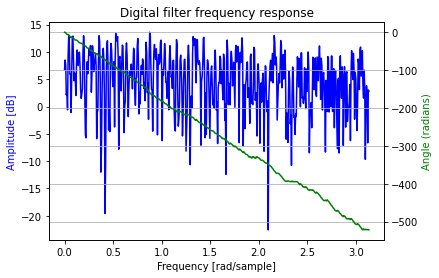

In [6]:
vn1 = velvet_noise(sr, 10, 8, -5)
plt.stem(vn1)
plt.title('First Velvet Noise')
plt.xlabel('Index')
plt.ylabel('Level')
plt.show()
plot_freqz(*signal.freqz(vn1))

# shelf filters
![shelf filters](https://s3.amazonaws.com/embeddedrelated/user/1/shelving_97220.jpg)

3.141209158392822 0.0


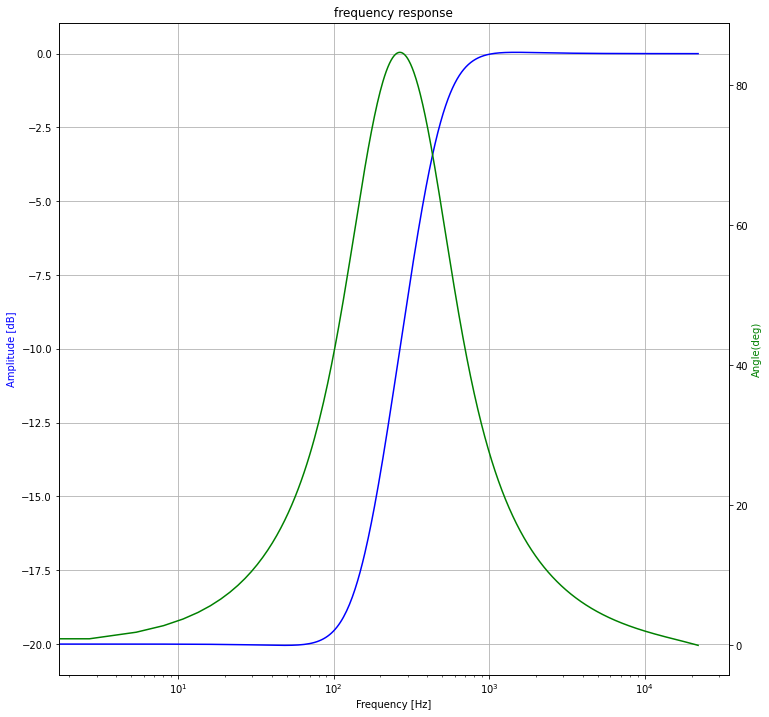

In [64]:
# https://www.dsprelated.com/showcode/170.php

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal


class Class_IIR_Shelving(object):
    def __init__(self, fc=2500, G=2.0, Q=1.0, fs=48000, shelf_type='Base_Shelf'):
        """
        %
        % Derive coefficients for a shelving filter with a given amplitude and
        % cutoff frequency.  All coefficients are calculated as described in 
        % Zolzer's DAFX book (p. 60 - 65).  
        %
        % Usage:     [B,A] = shelving(G, Fc, Fs, Q, type);
        %
        %            G is the logrithmic gain (in dB)
        %            Fc is the center frequency (in Hz)
        %            Fs is the sampling rate (in Hz)
        %            Q adjusts the slope be replacing the sqrt(2) term
        %            type is a character string defining filter type
        %                 Choices are: 'Base_Shelf' or 'Treble_Shelf'
        %
        % Author: Ruibin Yuan, 04/05/2022
        % Modified from: sparafucile17, 08/22/05
        %
        """
        # design iir Shelving filter
        # initalize
        self.fc = fc
        self.fs = fs
        self.G = G
        self.Q = Q
        support_shelf_type= ['Base_Shelf', 'Treble_Shelf']
        assert shelf_type in support_shelf_type, 'shelf_type must be in {}'.format(support_shelf_type)
        self.shelf_type = shelf_type
        self.b, self.a = self.set_shelving()

    def filtering(self, xin):
    	# process filtering, using scipy
    	# input xin
    	# output filtered xin
        return signal.lfilter(self.b, self.a, xin)
        
    def f_show(self, worN=1024):
        # draw frequency response, using scipy
        w, h = signal.freqz(self.b, self.a, worN=worN)
        print(w.max(), w.min())
        
        fig = plt.figure(figsize=(12,12))
        ax1 = fig.add_subplot(111)
        flist = w / ((2.0 * np.pi) / self.fs)
        plt.title('frequency response')
        
        plt.semilogx(flist, 20 * np.log10(abs(h)), 'b')  
        # plt.plot(flist, 20 * np.log10(abs(h)), 'b')
        
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.grid()
        
        ax2 = ax1.twinx()
        angles = np.unwrap(np.angle(h))
        angles = angles / ((2.0 * np.pi) / 360.0)
        plt.semilogx(flist, angles, 'g')  
        # plt.plot(flist, angles, 'g')
        plt.ylabel('Angle(deg)', color='g')
        
        plt.axis('tight')
        plt.show()

    def set_shelving(self,):
        
        K = np.tan(np.pi * self.fc / self.fs)
        V0 = np.power(10.0, self.G/20.0)
        root2 = 1/self.Q # sqrt(2)

        # Invert gain if a cut
        if (V0 < 1):
            V0 = 1 / V0

        ####################
        #    BASE BOOST
        ####################
        if self.shelf_type == 'Base_Shelf' and self.G>0:
            b0 = (1 + np.sqrt(V0)*root2*K + V0*K**2) / (1 + root2*K + K**2)
            b1 =                (2 * (V0*K**2 - 1) ) / (1 + root2*K + K**2)
            b2 = (1 - np.sqrt(V0)*root2*K + V0*K**2) / (1 + root2*K + K**2)
            a1 =                   (2 * (K**2 - 1) ) / (1 + root2*K + K**2)
            a2 =                (1 - root2*K + K**2) / (1 + root2*K + K**2)

        ####################
        #    BASE CUT
        ####################
        elif self.shelf_type == 'Base_Shelf' and self.G<0:
            b0 =                (1 + root2*K + K**2) / (1 + root2*np.sqrt(V0)*K + V0*K**2)
            b1 =                   (2 * (K**2 - 1) ) / (1 + root2*np.sqrt(V0)*K + V0*K**2)
            b2 =                (1 - root2*K + K**2) / (1 + root2*np.sqrt(V0)*K + V0*K**2)
            a1 =                (2 * (V0*K**2 - 1) ) / (1 + root2*np.sqrt(V0)*K + V0*K**2)
            a2 = (1 - root2*np.sqrt(V0)*K + V0*K**2) / (1 + root2*np.sqrt(V0)*K + V0*K**2)

        ####################
        #    TREBLE BOOST
        ####################
        elif self.shelf_type == 'Treble_Shelf' and self.G>0:
            b0 = (V0 + root2*np.sqrt(V0)*K + K**2) / (1 + root2*K + K**2)
            b1 =                (2 * (K**2 - V0) ) / (1 + root2*K + K**2)
            b2 = (V0 - root2*np.sqrt(V0)*K + K**2) / (1 + root2*K + K**2)
            a1 =                 (2 * (K**2 - 1) ) / (1 + root2*K + K**2)
            a2 =              (1 - root2*K + K**2) / (1 + root2*K + K**2)

        ####################
        #    TREBLE CUT
        ####################
        elif self.shelf_type == 'Treble_Shelf' and self.G<0:
            b0 =                  (1 + root2*K + K**2) / (V0 + root2*np.sqrt(V0)*K + K**2)
            b1 =                     (2 * (K**2 - 1) ) / (V0 + root2*np.sqrt(V0)*K + K**2)
            b2 =                  (1 - root2*K + K**2) / (V0 + root2*np.sqrt(V0)*K + K**2)
            a1 =                (2 * ((K**2)/V0 - 1) ) / (1 + root2/np.sqrt(V0)*K + (K**2)/V0)
            a2 = (1 - root2/np.sqrt(V0)*K + (K**2)/V0) / (1 + root2/np.sqrt(V0)*K + (K**2)/V0)
        
        ####################
        #    All-Pass
        ####################
        else:
            b0 = V0
            b1 = 0
            b2 = 0
            a1 = 0
            a2 = 0
        
        a = np.array([1, a1, a2])
        b = np.array([b0, b1, b2])

        return b, a


if __name__ == '__main__':
    
    # high shelf filter sample 
    iir_LS1=Class_IIR_Shelving( fc=50, G=-20, Q=0.75, fs=44100, shelf_type='Base_Shelf')
    # draw frequency response
    iir_LS1.f_show(8192)